# Analysis

## Boilerplate

In [1]:
import argparse
import freud
import hoomd
import json
import matplotlib
import os
import signac

import gsd
import gsd.hoomd
import gsd.pygsd

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import linregress

Choose one statepoint to work with at random

In [2]:
project = signac.get_project()
job_list = []
for job in project:
    job_list.append(job)

job = job_list[1]

Unit conversions:

In [3]:
from utility import *
SP = JobParser(job)

# the following relations assume that sigma = 1
R = (SP.freedom_rat * SP.aspect_rat) / 2
N_mesh = int(4 * np.pi * R**2 / SP.TriArea) + 2
cylinder_vol = SP.aspect_rat * np.pi * (1 / 2) ** 2

BG = BuoyancyAndGravity(R, N_mesh, cylinder_vol)

speed_conv = BG.len_conv / BG.time_conv # m/s per 1 speed sim unit
speed_conv_mm = speed_conv*1e3
time_conv_ms = BG.time_conv *1e3
len_conv_um = BG.len_conv *1e6
time_conv_min = BG.time_conv /60

time unit conversion:  0.005845586908136183 sec/sim unit
F_grav_mesh:  5.806537486708131  F_grav_rod:  67.43330608117216
F_boy_mesh:  5.723552374411988  F_boy_rod:  61.71351672607273
F_const_mesh:  -0.08298511229614292  F_const_rod:  -5.719789355099429


In [4]:
print(BG.time_conv)
print(BG.len_conv)
print(BG.energy_conv)
print(BG.mass_conv)
print(speed_conv)
print(len_conv_um)

0.005845586908136183
3e-06
2.0709735e-20
7.863e-14
0.0005132076636863355
3.0


In [5]:
step_to_sec = BG.time_conv * SP.dt

In [6]:
1e7*BG.time_conv * 0.0001

5.845586908136183

In [7]:
#############################################
## Collect positions
#############################################
   
#f = gsd.pygsd.GSDFile(open(job.fn('active.gsd'), 'rb'))
f = gsd.pygsd.GSDFile(open(job.fn('Demo.gsd'), 'rb'))
traj = gsd.hoomd.HOOMDTrajectory(f)
    
time_indices = np.arange(len(traj))

timesteps = time_indices * 10000
timestesp_exp = timesteps*step_to_sec

cmap_red = plt.get_cmap('Reds')
cmap_blue = plt.get_cmap('Blues')
norm = plt.Normalize(vmin=timesteps.min(), vmax=timesteps.max())

# all positions of every particle over time
all_mesh_positions = []
all_active_positions = []

# positions of coms over time
mesh_com_positions   = []
mesh_com_velocities  = []
active_com_positions = []
active_orientations  = []
active_com_velocities = []
    
for frame in traj:
    
    positions = frame.particles.position
    velocities = frame.particles.velocity
    typeids = frame.particles.typeid
    orientations = frame.particles.orientation

    # Mesh particles
    mask = (typeids == 0)
    mesh_positions = positions[mask]
    all_mesh_positions.append(mesh_positions)
    mesh_com_positions.append(np.average(mesh_positions, axis=0))

    mesh_velocities = velocities[mask]
    mesh_com_velocities.append(np.average(mesh_velocities, axis=0))

    # Active rods
    mask = (typeids == 1)
    active_positions = positions[mask]
    all_active_positions.append(active_positions)
    active_com_positions.append(np.average(active_positions, axis=0)) #works for multiple rods

    active_velocities = velocities[mask]
    active_com_velocities.append(np.average(active_velocities, axis=0))
    
    active_orientations.append(orientations[mask]) #only works for 1 active rod right now

mesh_com_positions = np.array(mesh_com_positions)
active_com_positions = np.array(active_com_positions)

print("Positions taken successfully from GSD.")

Positions taken successfully from GSD.


In [8]:
i = 1
print(mesh_com_positions[i])
print(active_com_positions[i])

[-0.29559946 -0.9146064  -0.15091273]
[-0.34967667 -0.8260212  -0.31203407]


In [9]:
np.inner(mesh_com_positions[i], active_com_positions[i])

np.float32(0.90593845)

In [10]:
mesh_com_v_norms = []
active_com_v_norms = []

for i in range(len(time_indices)):
    mesh_com_v_norms.append(np.linalg.norm(mesh_com_positions[i]))
    active_com_v_norms.append(np.linalg.norm(active_com_positions[i]))

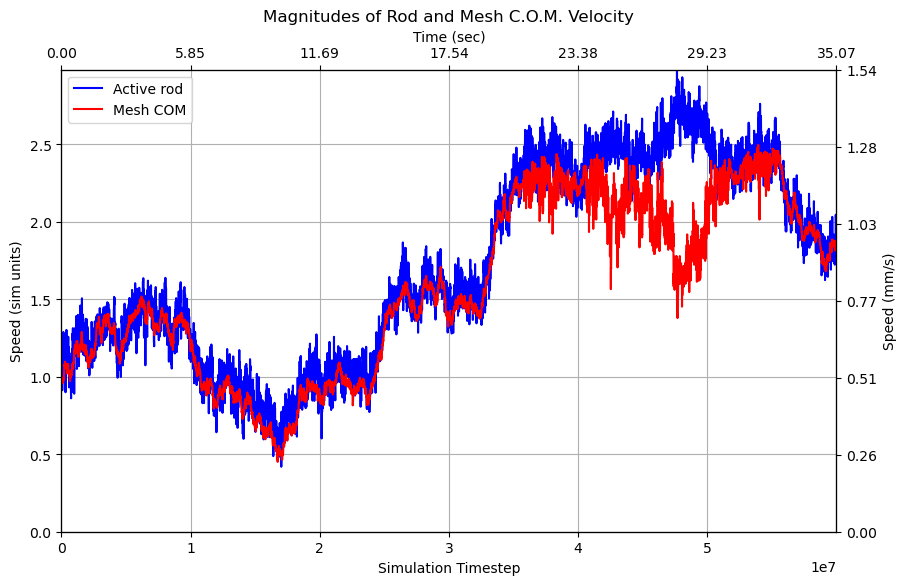

In [11]:
# Note that the experimental y labels are not converting correcytly

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('white')
ax.plot(timesteps, active_com_v_norms, label="Active rod", color='blue')
ax.plot(timesteps, mesh_com_v_norms, label="Mesh COM", color='red')

ax.set_xlim(left=0)
ax.set_xlim(right=max(timesteps))
ax.set_ylim(bottom=0)
ax.set_ylim(top=max([max(active_com_v_norms),max(mesh_com_v_norms)]))

# second axes for exp units
ax2 = ax.twinx()
ax2.set_ylabel("Speed (mm/s)")
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels([f"{tick * speed_conv_mm:.2f}" for tick in ax.get_yticks()])  # Convert the tick labels

ax3 = ax.twiny()
ax3.set_xlabel(r"Time (sec)")  
ax3.set_xticks(ax.get_xticks())  
ax3.set_xticklabels([f"{tick * step_to_sec:.2f}" for tick in ax.get_xticks()]) 

ax.set_xlabel("Simulation Timestep")
ax.set_ylabel("Speed (sim units)")
ax.legend(loc='best')

ax.set_title(f"Magnitudes of Rod and Mesh C.O.M. Velocity")
ax.grid(True)



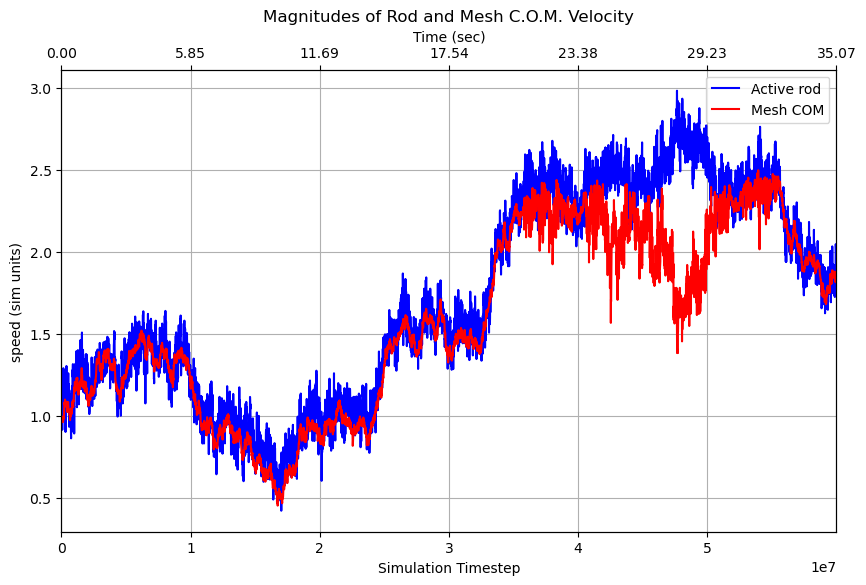

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('white')
ax.plot(timesteps, active_com_v_norms, label="Active rod", color='blue')
ax.plot(timesteps, mesh_com_v_norms, label="Mesh COM", color='red')
ax.set_xlabel("Simulation Timestep")
ax.set_ylabel("speed (sim units)")

ax.set_xlim(left=0)
ax.set_xlim(right=max(timesteps))

ax3 = ax.twiny()
ax3.set_xlabel(r"Time (sec)")  
ax3.set_xticks(ax.get_xticks())  
ax3.set_xticklabels([f"{tick * step_to_sec:.2f}" for tick in ax.get_xticks()]) 

ax.legend(loc='best')
ax.set_title(f"Magnitudes of Rod and Mesh C.O.M. Velocity")
ax.grid(True)
#fig.savefig(job.fn('velocity_magnitudes.png'), dpi=300, bbox_inches='tight', facecolor='white')
#plt.close()

In [13]:
velocity_dots = []
normalized_v_dots = []

for i in range(len(time_indices)):
    velocity_dots.append(np.inner(mesh_com_positions[i], active_com_positions[i]))
    normalized_v_dots.append(np.inner(mesh_com_positions[i]/mesh_com_v_norms[i], active_com_positions[i]/active_com_v_norms[i]))

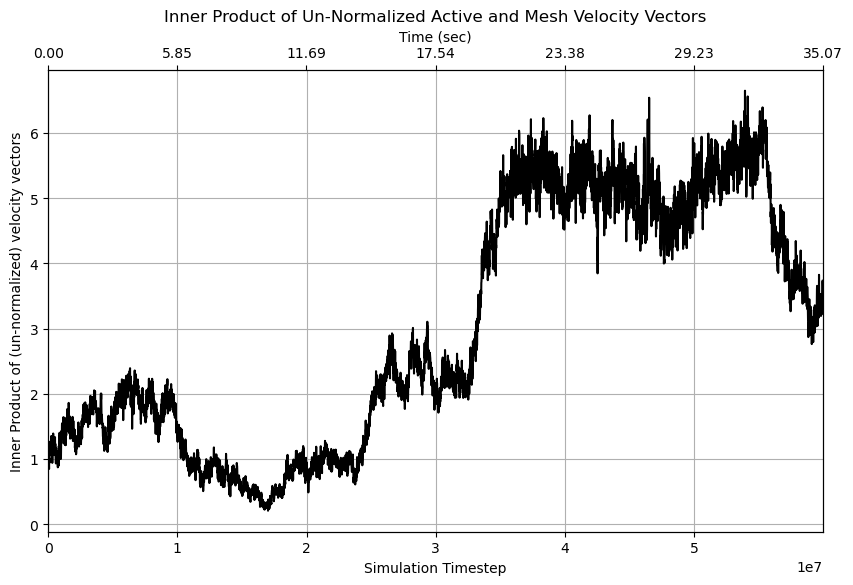

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('white')
ax.plot(timesteps, velocity_dots, color='black')
ax.set_xlabel("Simulation Timestep")
ax.set_ylabel("Inner Product of (un-normalized) velocity vectors")

ax.set_xlim(left=0)
ax.set_xlim(right=max(timesteps))

ax3 = ax.twiny()
ax3.set_xlabel(r"Time (sec)")  
ax3.set_xticks(ax.get_xticks())  
ax3.set_xticklabels([f"{tick * step_to_sec:.2f}" for tick in ax.get_xticks()]) 

ax.set_title(f"Inner Product of Un-Normalized Active and Mesh Velocity Vectors")
ax.grid(True)
#fig.savefig(job.fn('v_dots_UNnorm.png'), dpi=300, bbox_inches='tight', facecolor='white')
#plt.close()

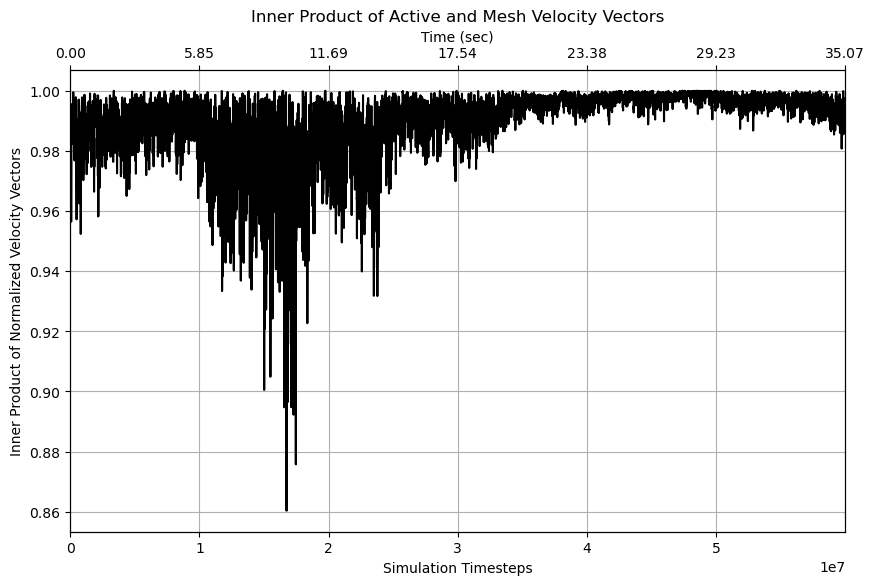

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('white')
ax.plot(timesteps, normalized_v_dots, color='black')
ax.set_xlabel("Simulation Timesteps")
ax.set_ylabel("Inner Product of Normalized Velocity Vectors")
ax.set_title(f"Inner Product of Active and Mesh Velocity Vectors")

ax.set_xlim(left=0)
ax.set_xlim(right=max(timesteps))

ax3 = ax.twiny()
ax3.set_xlabel(r"Time (sec)")  # Label for the second x-axis
ax3.set_xticks(ax.get_xticks())  # Set the ticks of the second x-axis to match the first one
ax3.set_xticklabels([f"{tick * step_to_sec:.2f}" for tick in ax.get_xticks()])  # Convert the tick labels

ax.grid(True)
#fig.savefig(job.fn('v_dots_norm.png'), dpi=300, bbox_inches='tight', facecolor='white')
#plt.close()

In [16]:
print(job.fn('v_dots_norm.png'))

/anvil/scratch/x-kjensen/single_rod_flex_aspectRat/workspace/06aea204f67f85ca64be92ce5f0691a3/v_dots_norm.png


In [17]:
# To be saved to overall file. 
std_norm_v_dot = np.std(normalized_v_dots)
avg_norm_v_dot = np.average(normalized_v_dots)
max_norm_v_dot = max(normalized_v_dots)
min_norm_v_dot = min(normalized_v_dots)

XY Trajectories plotted.


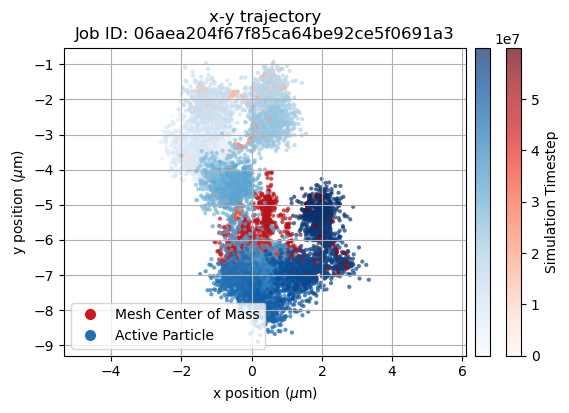

In [18]:
#############################################
## Plot and save x-y plane trajectories
#############################################
    
mesh_x = mesh_com_positions[:, 0]
mesh_y = mesh_com_positions[:, 1]
mesh_z = mesh_com_positions[:, 2]

active_x = active_com_positions[:, 0]
active_y = active_com_positions[:, 1]
active_z = active_com_positions[:, 2]

# mid colors for legend
mid_color_mesh = cmap_red(norm(timesteps[int(3*len(timesteps)/4)]))  
mid_color_active = cmap_blue(norm(timesteps[int(3*len(timesteps)/4)])) 

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_facecolor('white')

sc_mesh = ax.scatter(mesh_x*len_conv_um, mesh_y*len_conv_um, 
                    c=timesteps, cmap=cmap_red, 
                    norm=norm, label="Mesh Center of Mass", s=9, alpha=0.7, edgecolor='none')
sc_active = ax.scatter(active_x*len_conv_um, active_y*len_conv_um, 
                    c=timesteps, cmap=cmap_blue, 
                    norm=norm, label="Active Particle", s=9, alpha=0.7, edgecolor='none')


cbar_com = fig.colorbar(sc_mesh, ax=ax, orientation='vertical', fraction=0.05, pad=0.02)
cbar_com.set_label('Simulation Timestep')
cbar_active = fig.colorbar(sc_active, orientation='vertical', fraction=0.05, pad=0.02)
cbar_active.ax.yaxis.set_ticks([])

from matplotlib.lines import Line2D
legend_mesh = Line2D([0], [0], marker='o', color='w', markerfacecolor=mid_color_mesh, markersize=9, label="Mesh Center of Mass")
legend_active = Line2D([0], [0], marker='o', color='w', markerfacecolor=mid_color_active, markersize=9, label="Active Particle")

ax.legend(handles=[legend_mesh, legend_active], loc='best')

ax.set_xlabel(r"x position ($\mu$m)")
ax.set_ylabel(r"y position ($\mu$m)")
ax.set_title(f"x-y trajectory\nJob ID: {job}")

ax.axis('equal')
ax.grid()

#plt.show()
#fig.savefig(job.fn('xy_traj.png'), dpi=150, bbox_inches='tight', facecolor='white')
#plt.close()

print('XY Trajectories plotted.')

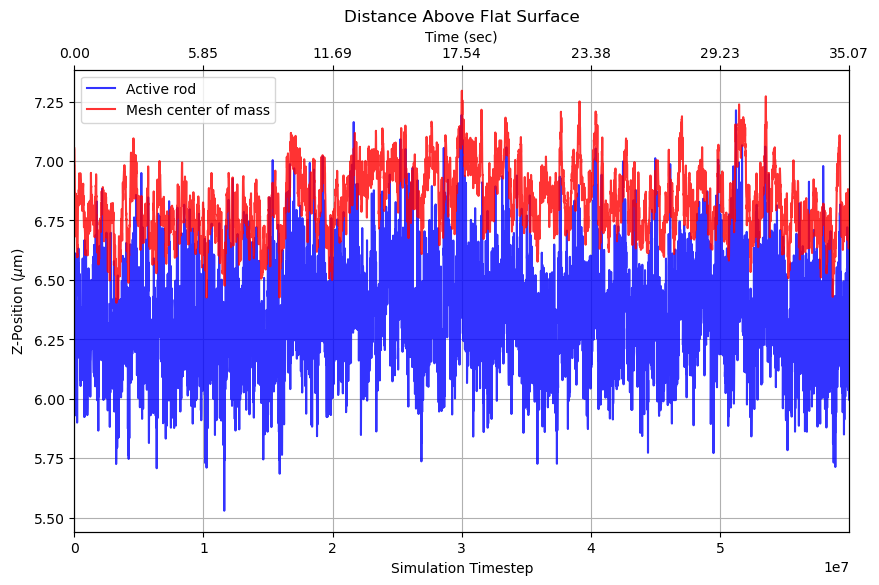

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('white')
ax.plot(timesteps, (active_z+R+1)*len_conv_um, label="Active rod", color='blue', alpha=0.8)
ax.plot(timesteps, (mesh_z+R+1)*len_conv_um, label="Mesh center of mass", color='red', alpha = 0.8)
ax.set_xlabel("Simulation Timestep")
ax.set_ylabel(r"Z-Position ($\mu$m)")

ax.set_xlim(left=0)
ax.set_xlim(right=max(timesteps))

ax.legend(loc='best')
ax.set_title(f"Distance Above Flat Surface")

ax3 = ax.twiny()
ax3.set_xlabel(r"Time (sec)")  # Label for the second x-axis
ax3.set_xticks(ax.get_xticks())  # Set the ticks of the second x-axis to match the first one
ax3.set_xticklabels([f"{tick * step_to_sec:.2f}" for tick in ax.get_xticks()])  # Convert the tick labels

ax.grid(True)
#fig.savefig(job.fn('d_from_floor.png'), dpi=300, bbox_inches='tight', facecolor='white')
#plt.close()

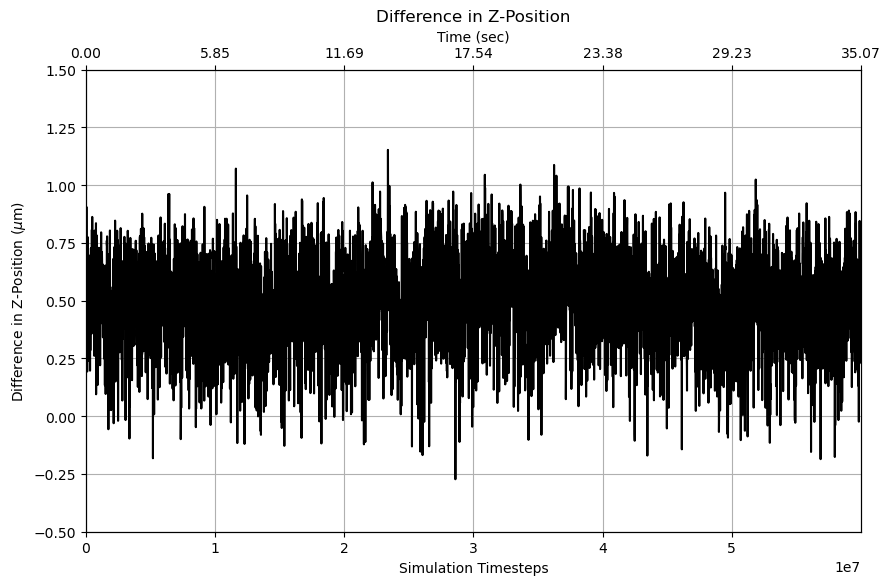

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('white')
z_diff = (mesh_z - active_z)*len_conv_um
ax.plot(timesteps, z_diff, color='black')
ax.set_xlabel("Simulation Timesteps")
ax.set_ylabel(r"Difference in Z-Position ($\mu$m)")

# Set limits to be height of mesh
lim = R
if max(z_diff) > abs(min(z_diff)):
    if max(z_diff) > lim:
        lim = max(z_diff)
else:
    if abs(min(z_diff)) > lim:
        lim = abs(min(z_diff))

ax.set_xlim(left=0)
ax.set_xlim(right=max(timesteps))
ax.set_ylim(top=lim)
ax.set_ylim(bottom=-lim+1)


ax.set_title(f"Difference in Z-Position")

ax3 = ax.twiny()
ax3.set_xlabel(r"Time (sec)")  # Label for the second x-axis
ax3.set_xticks(ax.get_xticks())  # Set the ticks of the second x-axis to match the first one
ax3.set_xticklabels([f"{tick * step_to_sec:.2f}" for tick in ax.get_xticks()])  # Convert the tick labels

ax.grid(True)
#fig.savefig(job.fn('diff_d_from_floor.png'), dpi=300, bbox_inches='tight', facecolor='white')
#plt.close()

In [21]:
max(z_diff)

np.float32(1.1529186)

In [22]:
#############################################
## Spherical deformation
#############################################
    
final_pos = all_mesh_positions[-1][:]
axes = [(max(final_pos[:, 0]) - min(final_pos[:, 0]))* len_conv_um,
        (max(final_pos[:, 1]) - min(final_pos[:, 1]))* len_conv_um,
        (max(final_pos[:, 2]) - min(final_pos[:, 2]))* len_conv_um]
    
# Mesh length, width, height aspect ratios:
ratio_xz = axes[0] / axes[2]
ratio_yz = axes[1] / axes[2]
ratio_xy = axes[0] / axes[1]

# Polar eccentricity: 
'''
e = 0 is perfect sphere.
e --> 1 with infinite deformation
Here, we assume symmetry along x-y plane and take average.
We assume z axis is shorter than x-y because of gravity.
Else, we set e to NaN.
'''
max_ax = (axes[0] + axes[1])/2 # assume xy symmetry
min_ax = axes[2] # set to axis_z
eccen = 1 - (min_ax * min_ax) / (max_ax * max_ax)

if eccen < 0:
    eccen = np.nan  # Set to NaN
else:
    eccen = np.sqrt(eccen)

# Volume deviations:
R_avg = (axes[0] * axes[1] * axes[2])**(1/3)
V_sphere = (4/3) * np.pi * R_avg**3
V_actual = (4/3) * np.pi * axes[0] * axes[1] * axes[2]
V_diff_sqr = (V_actual - V_sphere)**2

# Sphericity: (assume oblate spheriod)
'''
Phi = 1 for perfect sphere
Phi > 1 as deformations increase.
Here, we assume symmetry along the x-y plane.
We asume z-axis is shorted than x-y because of gravity. (ie. oblate)
Else, we set Phi to NaN
'''
SA_sphere = (4 * np.pi)**(1/3) * ((3 * V_actual)**(2/3))
SA_actual = 2 * np.pi * max_ax**2 * (1 + (min_ax/(max_ax * eccen)) * np.arcsin(eccen))
SA_diff_sqr = (SA_actual - SA_sphere)**2
Phi = SA_actual / SA_sphere

print('Spherical deformation analysis completed.')

Spherical deformation analysis completed.


In [23]:
#############################################
## Active-mesh positional change
#############################################
    
# Peason correlation of active and mesh com positions 
'''
1:  perfect correlation
0:  no correlation
-1: perfect neg correlation
'''
Pear_corrs = []
for i in range(3):  # We have three dimensions: x, y, z
    corr = np.corrcoef(mesh_com_positions[:, i], active_com_positions[:, i])[0, 1]
    Pear_corrs.append(corr)

In [37]:
# Displacement and total distance travelled
active_init_pos = active_com_positions[0]
com_init_pos = mesh_com_positions[0]
active_total_distance = 0
mesh_total_distance = 0

disp_active = []
disp_mesh = []
active_total_distances = []
mesh_total_distances = []

disp_active.append(0)
disp_mesh.append(0)
active_total_distances.append(0)
mesh_total_distances.append(0)

for t in range(1, len(time_indices)):
    # Displacements
    disp = active_com_positions[t] - active_init_pos
    disp_active.append(np.linalg.norm(disp))
        
    disp = mesh_com_positions[t] - com_init_pos
    disp_mesh.append(np.linalg.norm(disp))

    # Total distance and MSDs
    vector = active_com_positions[t]-active_com_positions[t-1]
    active_total_distance += np.linalg.norm(vector)
    active_total_distances.append(active_total_distances[t-1]+np.linalg.norm(vector))

    vector = mesh_com_positions[t]-mesh_com_positions[t-1]
    mesh_total_distance += np.linalg.norm(vector)
    mesh_total_distances.append(mesh_total_distances[t-1]+np.linalg.norm(vector))

disp_corr = np.corrcoef(disp_active, disp_mesh)[0, 1]

disp_active = np.array(disp_active)
disp_mesh = np.array(disp_mesh)
active_total_distances = np.array(active_total_distances)
mesh_total_distances = np.array(mesh_total_distances)

print('Displacement calculated.') 

Displacement calculated.


In [ ]:
# Convert to experimental units (um)
disp_active_um = disp_active * len_conv_um
disp_mesh_um = disp_mesh * len_conv_um
active_total_distances_um = active_total_distances * len_conv_um
mesh_total_distances_um = mesh_total_distances * len_conv_um
active_total_distance_um = active_total_distance * len_conv_um
mesh_total_distance_um = mesh_total_distance * len_conv_um

In [38]:
print(active_total_distance)
print(mesh_total_distance)

843.66315
224.9141


Distance Travelled plotted.


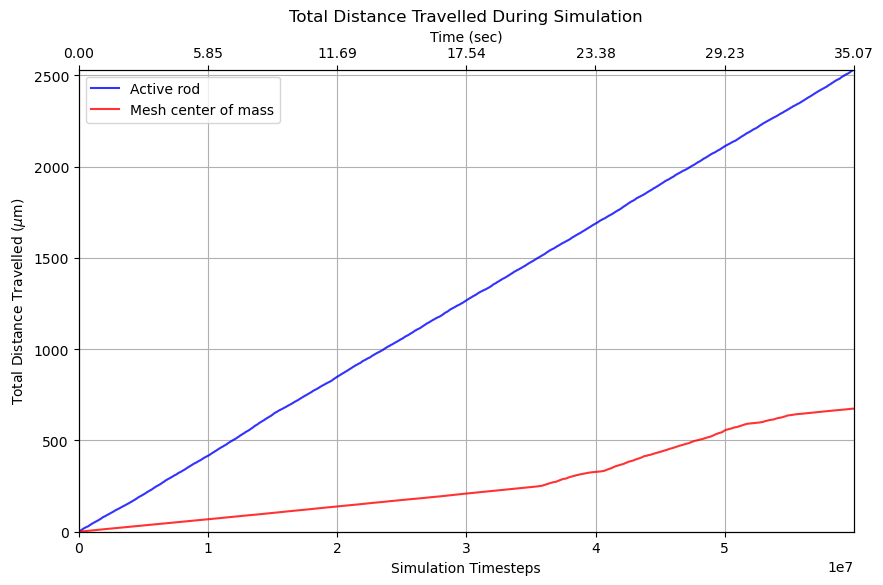

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('white')
ax.plot(timesteps, active_total_distances_um, label="Active rod", color='blue', alpha = 0.8)
ax.plot(timesteps, mesh_total_distances_um, label="Mesh center of mass", color='red', alpha = 0.8)
ax.set_xlabel("Simulation Timesteps")
ax.set_ylim(bottom=0)
ax.set_ylim(top=max([max(mesh_total_distances_um),max(active_total_distances_um)]))
ax.set_xlim(left=0)
ax.set_xlim(right=max(timesteps))
ax.set_ylabel(r"Total Distance Travelled ($\mu$m)")
ax.legend(loc='best')
ax.set_title(f"Total Distance Travelled During Simulation")#\nCorrelation: {disp_corr:.2f}")

ax3 = ax.twiny()
ax3.set_xlabel(r"Time (sec)")  # Label for the second x-axis
ax3.set_xticks(ax.get_xticks())  # Set the ticks of the second x-axis to match the first one
ax3.set_xticklabels([f"{tick * step_to_sec:.2f}" for tick in ax.get_xticks()])  # Convert the tick labels


ax.grid(True)
#fig.savefig(job.fn('total_dist.png'), dpi=300, bbox_inches='tight', facecolor='white')
#plt.close()

print('Distance Travelled plotted.')  

MSD plotted.


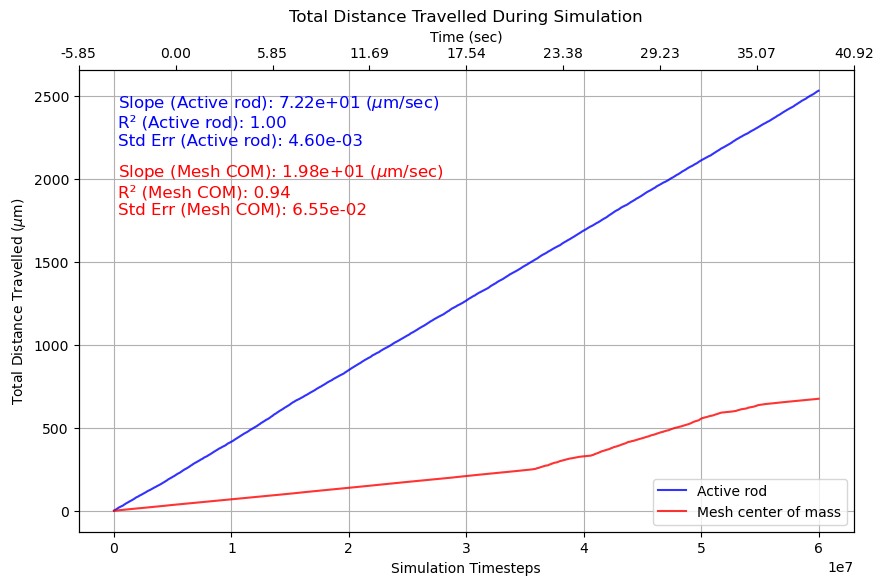

In [44]:
# Linear Regression
slope_active, intercept_active, r_value_active, p_value_active, std_err_active = linregress(timestesp_exp, active_total_distances_um)
r_squared_active = r_value_active ** 2

slope_mesh, intercept_mesh, r_value_mesh, p_value_mesh, std_err_mesh = linregress(timestesp_exp, mesh_total_distances_um)
r_squared_mesh = r_value_mesh ** 2


fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('white')
ax.plot(timesteps, active_total_distances_um, label="Active rod", color='blue', alpha=0.8)
ax.plot(timesteps, mesh_total_distances_um, label="Mesh center of mass", color='red', alpha=0.8)

# Annotating slope and R2 values
ax.text(0.05, 0.95, f"Slope (Active rod): {slope_active:.2e}"+r" ($\mu$m/sec)"+f"\nR² (Active rod): {r_squared_active:.2f}\nStd Err (Active rod): {std_err_active:.2e}",
        transform=ax.transAxes, fontsize=12, verticalalignment='top', color='blue')

ax.text(0.05, 0.8, f"Slope (Mesh COM): {slope_mesh:.2e}"+r" ($\mu$m/sec)"+f"\nR² (Mesh COM): {r_squared_mesh:.2f}\nStd Err (Mesh COM): {std_err_mesh:.2e}",
        transform=ax.transAxes, fontsize=12, verticalalignment='top', color='red')

ax3 = ax.twiny()
ax3.set_xlabel(r"Time (sec)")  # Label for the second x-axis
ax3.set_xticks(ax.get_xticks())  # Set the ticks of the second x-axis to match the first one
ax3.set_xticklabels([f"{tick * step_to_sec:.2f}" for tick in ax.get_xticks()])  # Convert the tick labels


ax.set_xlabel("Simulation Timesteps")
ax.set_ylabel(r"Total Distance Travelled ($\mu$m)")
ax.legend(loc='best')
ax.set_title(f"Total Distance Travelled During Simulation")
ax.grid(True)

# Optionally, save the plot
# fig.savefig(job.fn('total_dist_Wslopes.png'), dpi=300, bbox_inches='tight', facecolor='white')

#plt.show()


print('MSD plotted.')

Displacement plotted.


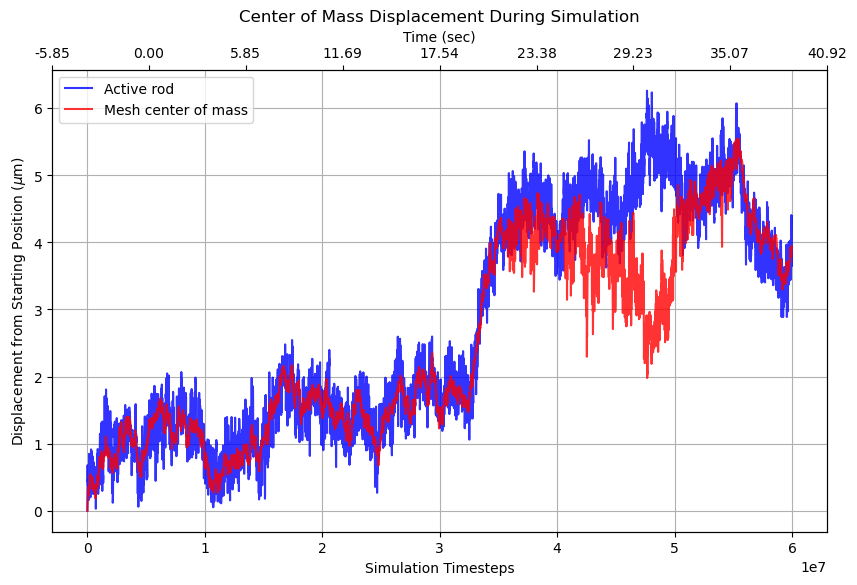

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('white')
ax.plot(timesteps, disp_active_um, label="Active rod", color='blue', alpha = 0.8)
ax.plot(timesteps, disp_mesh_um, label="Mesh center of mass", color='red', alpha = 0.8)
ax.set_xlabel("Simulation Timesteps")
ax.set_ylabel(r"Displacement from Starting Position ($\mu$m)")
ax.legend(loc='best')
ax.set_title(f"Center of Mass Displacement During Simulation")#\nCorrelation: {disp_corr:.2f}")
ax.grid(True)

ax3 = ax.twiny()
ax3.set_xlabel(r"Time (sec)")  # Label for the second x-axis
ax3.set_xticks(ax.get_xticks())  # Set the ticks of the second x-axis to match the first one
ax3.set_xticklabels([f"{tick * step_to_sec:.2f}" for tick in ax.get_xticks()])  # Convert the tick labels

#fig.savefig(job.fn('displacements.png'), dpi=300, bbox_inches='tight', facecolor='white')
#plt.close()

print('Displacement plotted.')  

In [43]:
#############################################
## Save results to json file
#############################################

all_data = {
    "jobid": job.id,
}
statepoints = job.sp
all_data.update(statepoints)

analysis_data = {
    "mesh_len_ratio_xz": float(ratio_xz),
    "mesh_len_ratio_yz": float(ratio_yz),
    "mesh_len_ratio_xy": float(ratio_xy),
    "eccentricity":      float(eccen),
    "spherical_volume":  float(V_sphere), #um^3
    "ellipsoidal_volume": float(V_actual* len_conv_um**3), #um^3
    "volume_square_difference": float(V_diff_sqr), #um^6
    "spherical_SA":         float(SA_sphere), #um^2
    "ellipsoidal_volume":   float(SA_actual), #um^3 (?)
    "SA_square_difference": float(SA_diff_sqr), #um^4
    "sphericity":           float(Phi),
    "pos_correlation_x":    float(Pear_corrs[0]),
    "pos_correlation_y":    float(Pear_corrs[1]),
    "pos_correlation_z":    float(Pear_corrs[2]),
    "displacement_correlation":    float(disp_corr),
    "distance_correlation":    float(dist_corr),
    "std_norm_v_dot": float(std_norm_v_dot),
    "avg_norm_v_dot": float(avg_norm_v_dot),
    "max_norm_v_dot": float(max_norm_v_dot),
    "min_norm_v_dot": float(min_norm_v_dot),
    "mesh_net_distance": float(disp_mesh_um[-1]), #um
    "active_net_distance": float(disp_active_um[-1]), #um
    "mesh_total_distance": float(mesh_total_distance_um), #um
    "active_total_distance": float(active_total_distance_um), #um
    "active_mesh_diff_distance": float(active_total_distance_um-mesh_total_distance_um), #um
    "slope_dist_mesh": float(slope_mesh), #um/sec
    "slope_err_dist_mesh": float(std_err_mesh),      #units?
    "slope_dist_active": float(slope_active), #um/sec
    "slope_err_dist_active": float(std_err_active),
    "slope_diff_dists": float(slope_active - slope_mesh) #um/sec
}
all_data.update(analysis_data)
with open(job.fn('analysis_data.json'), 'w') as f:
    json.dump(all_data, f, indent=4)

with open(job.fn('signac_job_document.json'), 'w') as f:
    json.dump(all_data, f, indent=4)

print('Analysis complete.')

Analysis complete.
